# Descriptive Vancouver Weather Classification from Measurements

### Introduction
In our present-day, weather forecasting is essential for providing vital information about severe weather threats and risk management (Weyn et al., 2019). However, this is difficult to model because weather is a chaotic system, and highly sensitive to initial conditions (Lorenz, 1963). Therefore, weather cannot be modeled simply by qualitative phenomenon description, due to chaos in the quantitative measurements of weather instruments. 

This project seeks to address the problem that quantitative measurements do not describe a qualitative pattern in isolation. Are chaotic systems such as weather, difficult to predictively model, able to be predictively classified? This project will use the k-nearest-neighbour model to classify weather based on quantitative predictive variables, and study the accuracy of this model to answer this.


The dataset we will use is [Historical Hourly Weather Data](https://www.kaggle.com/selfishgene/historical-hourly-weather-data). It includes data over separate csv files for different variables, like humidity.csv, pressure.csv etc. We are going to combine them into one dataset and focus on only the city of Vancouver due to the sheer volume of data, with date-time, description of weather, humidity, pressure, wind speed and temperature.

### Methods and Results

#### Loading, Tidying and Splitting Data:

##### Loading Libraries and Data

In [1]:
install.packages("themis")

library(tidyverse)
library(tidymodels)
library(themis)

humidity_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/humidity.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
pressure_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/pressure.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
temperature_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/temperature.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
wind_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/wind_speed.csv", col_types = cols()) %>%
            select(datetime, Vancouver)
description_van = read_csv("https://raw.githubusercontent.com/StuartLiv/DSCI100Group/main/data/weather_description.csv", col_types = cols()) %>%
            select(datetime, Vancouver)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0     ✔ recipes   0.2.0
✔ dials     0.0.9     ✔ rsample   0.0.7
✔ infer     0.5.4     ✔ tune

##### Merging Data Frames and Omitting Null Values

In [2]:
weather_data_verbose = left_join(humidity_van, pressure_van, by = "datetime") %>%
                left_join(temperature_van, by = "datetime") %>%
                left_join(wind_van, by = "datetime") %>%
                left_join(description_van, by = "datetime") %>%
                `colnames<-`(c("datetime", "humidity.pct", "pressure.kpa", "temperature.c", "wind_speed.ms", "description")) %>%
                na.omit() %>%
                mutate(temperature.c = temperature.c - 273.15)

##### Using Less Esoteric Weather Terms and Making Description a Factor

In [3]:
weather_data = weather_data_verbose %>% 
            filter(description != 'volcanic ash' & description != 'dust' & description != 'smoke' & description != 'haze') %>%
            mutate(description = case_when(description %in% c('broken clouds', 'few clouds', 'overcast clouds', 'scattered clouds') ~ 'cloudy',
                                           description %in% c('heavy intensity rain', 'heavy intensity shower rain', 'very heavy rain') ~ 'heavy rain',
                                           description %in% c('drizzle', 'light intensity drizzle', 'light intensity drizzle rain', 'light intensity shower rain', 'light rain and snow') ~ 'light rain',
                                           description %in% c('heavy shower snow', 'light shower snow', 'heavy snow', 'light snow', 'shower snow', 'sleet', 'light shower sleet') ~ 'snow',
                                           description %in% c('proximity thunderstorm', 'ragged thunderstorm', 'thunderstorm with heavy rain', 'thunderstorm with light rain', 'thunderstorm with rain') ~ 'thunderstorm',
                                           description %in% c('proximity shower rain', 'shower rain') ~ 'moderate rain',
                                           description == 'mist' ~ 'fog',
                                           description == 'sky is clear' ~ 'clear sky',
                                           TRUE ~ description)) %>%
            mutate(description = as.factor(description))

##### Splitting Data into Testing and Training Set

In [4]:
set.seed(1234)

weather_split <- initial_split(weather_data, prop = 0.80, strata = description)  
weather_train <- training(weather_split)   
weather_test <- testing(weather_split)

#weather_train is ~38000 rows, weather_test is ~2000 rows

####  Visualizations:

##### Distribution of each Weather Type in Training Data

In [5]:
sums = group_by(weather_train, description) %>%
    summarize(occurences = n(), .groups = 'drop') %>%
    #mutate(description = toTitleCase(description)) %>%
    setNames(c("Description:", "Occurences:")) %>%
    t() %>%
    cbind(c("total", nrow(weather_train)))

sums

Description:,clear sky,cloudy,fog,heavy rain,light rain,moderate rain,snow,thunderstorm,total
Occurences:,9008,10010,3420,518,4867,1703,483,20,30029


##### 6 Number Sumaries of Each Predictive Variable

In [6]:
summary(select(weather_train, -datetime, -description))

  humidity.pct     pressure.kpa  temperature.c    wind_speed.ms   
 Min.   : 12.00   Min.   : 810   Min.   :-28.00   Min.   : 0.000  
 1st Qu.: 73.00   1st Qu.:1012   1st Qu.:  6.46   1st Qu.: 1.000  
 Median : 86.00   Median :1017   Median : 10.77   Median : 2.000  
 Mean   : 81.99   Mean   :1018   Mean   : 11.00   Mean   : 2.549  
 3rd Qu.: 93.00   3rd Qu.:1022   3rd Qu.: 15.71   3rd Qu.: 4.000  
 Max.   :100.00   Max.   :1100   Max.   : 33.85   Max.   :25.000  

##### Distributions of Predictive Variables by Weather Type

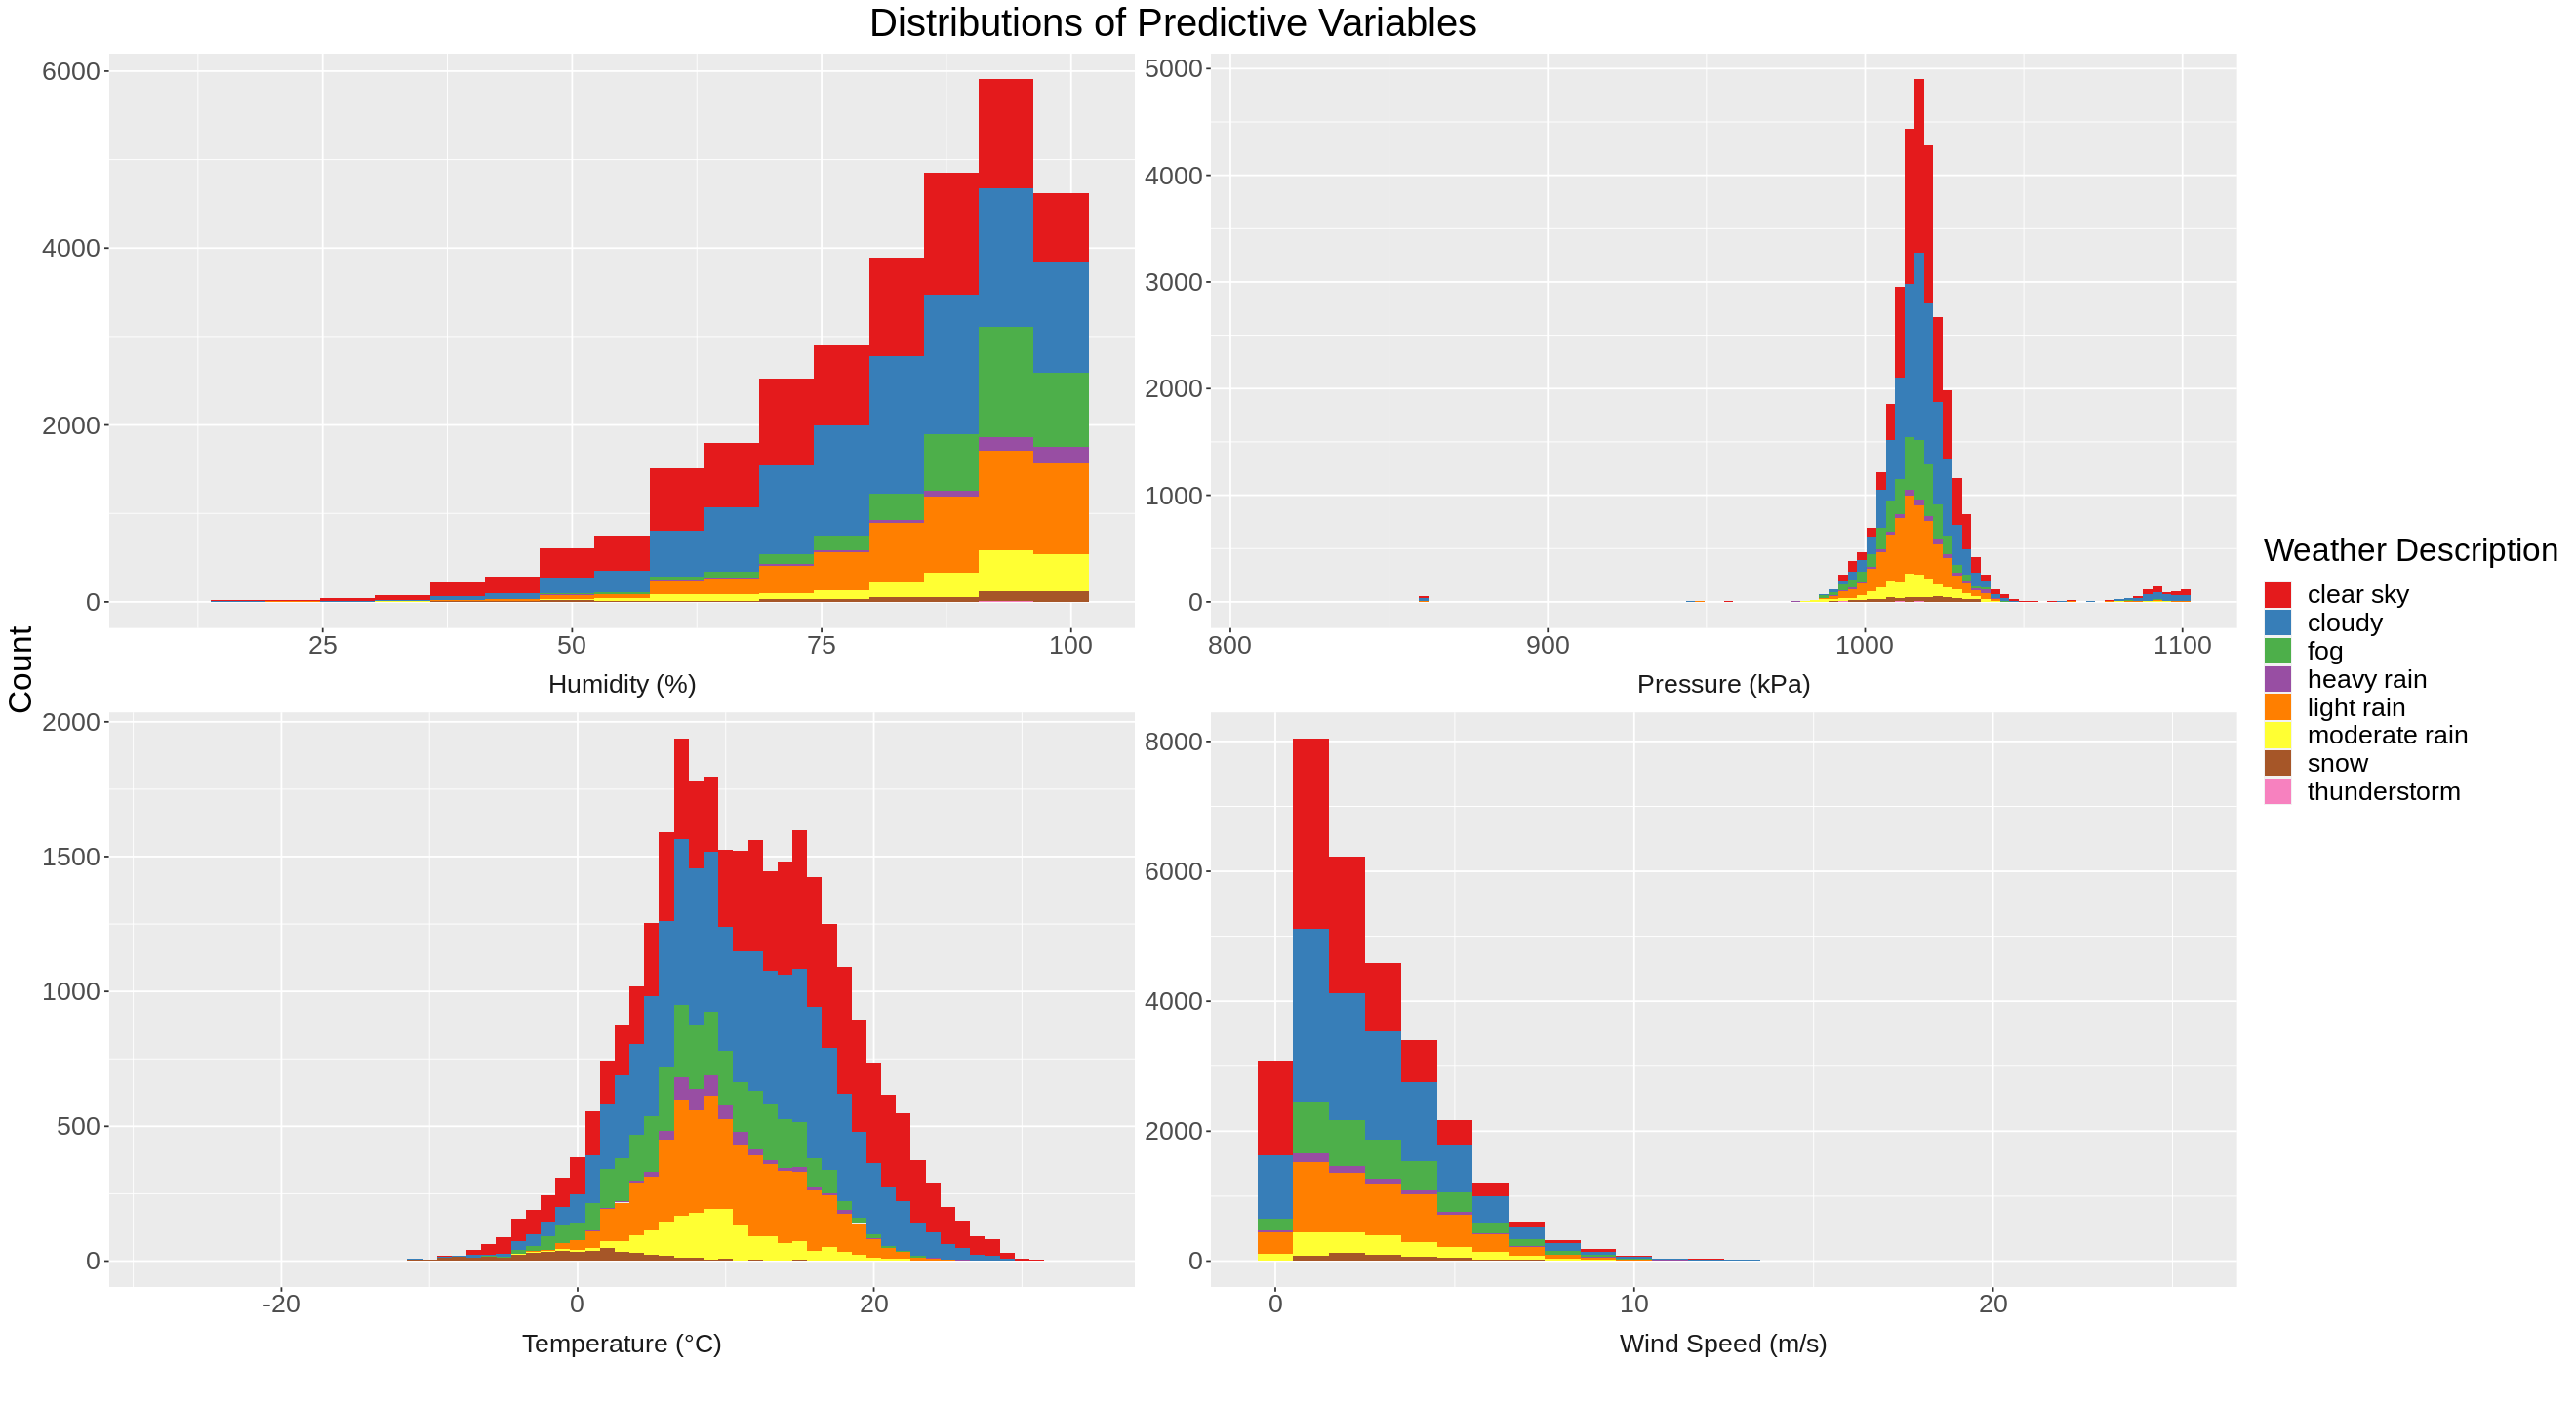

In [7]:
options(repr.plot.width = 22, repr.plot.height = 12) 

hist_data = pivot_longer(weather_train, c(temperature.c, pressure.kpa, humidity.pct, wind_speed.ms), 
            names_to = "measurement", values_to = "value")
hist_labels = as_labeller(c("humidity.pct" = "Humidity (%)", "pressure.kpa" = "Pressure (kPa)", "temperature.c" = "Temperature (°C)", "wind_speed.ms" = "Wind Speed (m/s)"))

hist_plot = ggplot(hist_data, aes(x = value, fill = description)) +
            ggtitle("Distributions of Predictive Variables") +
            geom_histogram(data = subset(hist_data, measurement == "humidity.pct"), binwidth = 5.5) + 
            geom_histogram(data = subset(hist_data, measurement == "pressure.kpa"), binwidth = 3) + 
            geom_histogram(data = subset(hist_data, measurement == "temperature.c"), binwidth = 1) + 
            geom_histogram(data = subset(hist_data, measurement == "wind_speed.ms"), binwidth = 1) + 
            facet_wrap(~measurement, scales = "free", strip.position = "bottom",  
                    labeller = hist_labels) +
            labs(x = "", y = "Count", fill = "Weather Description") + 
            scale_fill_brewer(palette = "Set1") +
            theme(strip.placement = "outside", strip.background = element_blank(), text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

hist_plot

#### Modeling:

##### Model Declaration

In [5]:
set.seed(1234)

weather_recipe <- recipe(description ~ humidity.pct + pressure.kpa + temperature.c + wind_speed.ms, data = weather_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_upsample(description, over_ratio = 1)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine('kknn') %>% 
    set_mode('classification')

weather_vfold <- vfold_cv(weather_train, v=5, strata = description)

knn_workflow <- workflow() %>% 
    add_recipe(weather_recipe) %>% 
    add_model(knn_tune)

##### Cross Validation and K Optimization
Note: These cells were run offline, due to being computationally expensivve, and the results are attatched here

![](https://raw.githubusercontent.com/StuartLiv/DSCI100Group/Stuart/data/Rplot.png)

From this plot, we choose k=2 for the final model

In [6]:
k<-2

knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = k) %>% 
    set_engine('kknn') %>% 
    set_mode('classification')

weather_fit = workflow() %>% 
    add_recipe(weather_recipe) %>% 
    add_model(knn_spec) %>% 
    fit(data = weather_train)

In [10]:
weather_predictions = predict(weather_fit, weather_test) %>% 
    bind_cols(weather_test)

weather_metrics = metrics(weather_predictions, 
                          truth = description, estimate = .pred_class)

weather_conf_mat = conf_mat(weather_predictions, 
                          truth = description, estimate = .pred_class)

weather_metrics
weather_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4442224
kap,multiclass,0.2628446


               Truth
Prediction      clear sky cloudy  fog heavy rain light rain moderate rain snow
  clear sky          1136    473  106         14        158            44   19
  cloudy              749   1468  283         39        387           136   28
  fog                 165    235  289         15        178            36   16
  heavy rain            8     15   14         38         18            15    0
  light rain          268    332  152         19        458            76   14
  moderate rain        72    106   54         13         73           133    5
  snow                 34     28   22          1         12             4   34
  thunderstorm          0      4    0          0          1             0    0
               Truth
Prediction      thunderstorm
  clear sky                0
  cloudy                   4
  fog                      3
  heavy rain               0
  light rain               1
  moderate rain            0
  snow                     0
  thunderstorm 

### Methods

(from proposal, integrate into above section)

We will only use data for Vancouver (for consistency of prediction and volume of data) for variables. We will predictively model weather descriptions from temperature, humidity, pressure, and wind speed, using k-nearest-neighbour classification after standardizing the data. We excluded wind direction, since it is more relevant for predicting the exact weather forecast, but not exactly relevant to predicting weather type descriptions. While these individual distributions may be crowded, using multiple variables will help us predict the weather type more accurately. Two observations could have the same temperature, for example, but the difference in their wind speeds and humidities might indicate that one observation was much windier and more humid than the other because it was during a storm. 

As visualizations we plan to graph the accuracy percentage for different k values from tuning the data set, which we will also select our testing k value from. Then, on the testing set, we will use a color-partitioned bar graph showing the actual weather description against where it was predictively assigned. This will be similar to our intended evaluation model, where we account for accuracy by each weather type, to minimize bias towards the most common weather patterns.


### Discussion

(from proposal, transform after results)

We expect our model to be biased towards the most common weather patterns. Since our dataset includes more data for clear sky and cloudy types, our testing data will be more likely classified as one of these two weathers by our k-nearest neighbour model. As the temperature and humidity statistics for different weathers like clear sky and cloudy does not seem differ significantly, k-nearest neighbour might not be the best method to classify data in this model. If the k-nearest neighbour model fails to classify a fair amount of testing data accurately as we predicted, it will show that k-nearest neighbour classification does not work well with quantitative data from a chaotic system like weather. 

Further questions this analysis could lead to are: are there any subsets of weather data able to be modeled by k-nearest neigbour classification considering the fact that chaotic systems have short-term patterns and repetition? If so, will factors like global warming greatly affect the accuracy of those classifications long term?



### References

Beniaguev, D. (2017, December 28). Historical hourly weather data 2012-2017. Kaggle. Retrieved February 27, 2022, from https://www.kaggle.com/selfishgene/historical-hourly-weather-data 

Lorenz, E. (1963). Deterministic Nonperiodic Flow. Journal of the Atmospheric Sciences,	20(2), 130-141. [https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2)

Weyn, Jonathan A., et al. (2019). Can Machines Learn to Predict Weather? Using DeepLearning to Predict Gridded 500‐hPa Geopotential Height From Historical Weather Data. Journal of Advances in Modeling Earth Systems, 11(8), 2680-2693.
https://doi.org/10.1029/2019MS001705

Total Words: 540